<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Dummy-data" data-toc-modified-id="Dummy-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dummy data</a></span></li><li><span><a href="#Cross-validation" data-toc-modified-id="Cross-validation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Cross-validation</a></span></li><li><span><a href="#Create-Tensorflow-DNN-model" data-toc-modified-id="Create-Tensorflow-DNN-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create Tensorflow DNN model</a></span></li><li><span><a href="#Bayesian-optimisation" data-toc-modified-id="Bayesian-optimisation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Bayesian optimisation</a></span></li></ul></div>

# Nodos

## Imports

In [1]:
# General:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys
import csv
import time
import shutil
import pickle
import logging

# Tensorflow:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K

# Sklearn
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error

# Scikit-Optimise
from skopt import gp_minimize, dump
from skopt.space import Categorical, Integer
from skopt.utils import use_named_args

# Statistics:
import scipy
from uncertainties import unumpy
import itertools
import statistics
itertools.imap = lambda *args, **kwargs: list(map(*args, **kwargs))

/Users/wilsonwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Dummy data

In [2]:
raw_data = pd.read_csv('~/OUTBRAIK/dataset.csv', index_col='Disease').drop('Region', axis=1)
corona = raw_data.iloc[[0],:]
raw_data = raw_data.iloc[1:,:]

In [3]:
shuffled = raw_data.sample(frac=1)
shuffled

,Death cases,Infected cases,Period of time (months),Population density inhab/km2,Population,GDP (trillion USD),Infection rate,Incidence rate (of 1000 people-month),Air traffic,Temperature C (1st month),Humidity %(1st month),Mortality rate,Epidemic or not
Disease,,,,,,,,,,,,,
2019 Measles Samoa,83.0,5707.0,4.0,64.83,196440.0,0.00,2.91,726.30,137770.0,30.0,75.0,1.45,1.0
2015 Influenza India,2035.0,33761.0,4.0,214.68,73471198.0,2.10,0.05,11.49,2887195.0,21.0,46.0,6.03,1.0
2017 Pneumonic Plague Madagascar,72.0,1618.0,3.0,198.00,3349000.0,0.01,0.05,16.10,366000.0,16.0,84.0,4.45,0.0
2002 Influenza Madagascar,156.0,1291.0,1.0,1876.74,161494.0,0.00,0.80,799.41,31000.0,14.4,80.0,12.08,0.0
2009 Influenza Mexico,80.0,4174.0,1.0,111.14,8000000.0,0.90,0.05,52.18,1586101.0,22.1,80.0,1.92,1.0
2012 MERS Saudi Arabia,449.0,1123.0,36.0,2295.63,3673000.0,0.73,0.03,0.85,21565000.0,32.0,56.0,39.98,1.0
2019 Measles Rep. Of the Congo,6000.0,250000.0,14.0,8745.77,2308000.0,0.01,10.83,773.71,627753.0,27.0,80.0,2.40,1.0
2019 MERS Qatar,0.0,3.0,0.5,4858.94,641380.0,0.19,0.00,0.94,38780000.0,26.0,54.0,0.00,0.0
2008 HFMD China,20.0,1884.0,1.0,74.47,728000.0,4.60,0.26,258.79,250000.0,9.2,79.3,1.06,1.0


In [4]:
train_set = shuffled.iloc[:10,:]
test_set = shuffled.iloc[10:,:]

## Cross-validation

In [5]:
def split_dataset(dataframe, n_splits):
    """Scikit-Learn KFold implementation for pandas DataFrame."""

    label_col = 'Epidemic or not'
    random_state = 2
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    kfolds = []

    for train, validate in kf.split(dataframe):
        training = dataframe.iloc[train]
        train_labels = training[label_col]
        train_set = training.drop(label_col, axis=1)

        validating = dataframe.iloc[validate]
        validate_labels = validating[label_col]
        validate_set = validating.drop(label_col, axis=1)

        kfolds.append(
            [[train_set, validate_set],
             [train_labels, validate_labels]]
        )

    with open('/Users/wilsonwu/OUTBRAIK/outbraik/data/06_models/kfolds.json', "wb") as file:
        pickle.dump(kfolds, file)

    logging.info('Pickled kfolds nested list to JSON.')
    return kfolds

## Create Tensorflow DNN model

In [17]:
?pd.DataFrame.values

In [6]:
def create_model(num_dense_layers_base, num_dense_nodes_base,
                 num_dense_layers_end, num_dense_nodes_end,
                 activation, adam_b1, adam_b2, adam_eps):
    
    num_input_nodes = 12
    
    # Craete linear stack of layers.
    model = keras.Sequential()

    # Define input layer.
    model.add(keras.layers.Dense(
        num_input_nodes,  # N.umber of nodes
        input_shape=(num_input_nodes,)  # Tuple specifying data input dimensions only needed in first layer.
             ))

    # Define n number of hidden layers (base, i.e. first layers).
    for i in range(num_dense_layers_base):
        model.add(keras.layers.Dense(
            num_dense_nodes_base,
            activation=activation
        ))

    # Define n number of hidden layers (end, i.e. last layers).
    for i in range(num_dense_layers_end):
        model.add(keras.layers.Dense(
            num_dense_nodes_end,
            activation=activation
        ))

    # Add two output nodes.
    model.add(keras.layers.Dense(1, activation=keras.activations.linear))
    
    model.add(keras.layers.Activation('sigmoid'))

    # Define dam optimiser.
    optimizer = tf.keras.optimizers.Adam(
        lr=0.0001,  # Learning rate
        beta_1=adam_b1,  # Exponential decay rate for the first moment estimates.
        beta_2=adam_b2,  # Exponential decay rate for the second-moment estimates.
        epsilon=adam_eps  # Prevent any division by zero.
    )

    # Compile model.
    model.compile(
        loss='mae',  # Loss function
        optimizer=optimizer,  # Optimisaion function defined above.
        metrics=['mae']  # Metric to be recorded.
    )

    return model

## Bayesian optimisation

In [19]:
def train_model(fold, fold_num, n_calls, epochs):
    """
    1. Unpack training data.
    2. Define hyper-perameter ranges.
    3. Define early stopping perameters.
    4. Optimise hyper-perameters and save best model.
    5. Save mae per call to CSV.
    """
    logging.info('Training fold {}.'.format(str(fold_num)))
    
    # Retrieve data sets and convert to numpy array.
    train_X = fold[0][0].values
    validate_X = fold[0][1].values
    train_y = fold[1][0].values
    validate_y = fold[1][1].values
    
    print(type(train_X))
    print(type(validate_X))
    print(type(train_y))
    print(type(validate_y))

    # Define hyper-perameters.
    # Layers
    dim_num_dense_layers_base = Integer(low=1, high=2, name='num_dense_layers_base')
    dim_num_dense_nodes_base = Categorical(categories=list(np.linspace(5, 261, 10, dtype=int)),
                                           name='num_dense_nodes_base')
    dim_num_dense_layers_end = Integer(low=1, high=2, name='num_dense_layers_end')
    dim_num_dense_nodes_end = Categorical(categories=list(np.linspace(5, 261, 10, dtype=int)),
                                          name='num_dense_nodes_end')

    # Optimiser
    dim_adam_b1 = Categorical(categories=list(np.linspace(0.8, 0.99, 11)), name='adam_b1')
    dim_adam_b2 = Categorical(categories=list(np.linspace(0.8, 0.99, 11)), name='adam_b2')
    dim_adam_eps = Categorical(categories=list(np.linspace(0.0001, 0.5, 11)), name='adam_eps')

    dimensions = [dim_num_dense_layers_base, dim_num_dense_nodes_base,
                  dim_num_dense_layers_end, dim_num_dense_nodes_end,
                  dim_adam_b1, dim_adam_b2, dim_adam_eps]

    # Set early stopping variable to prevent overfitting.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        mode='min',  # Monitoring loss
        patience=20,  # Large patience for small batch size
        verbose=0)  # Do not output to terminal

    best_mae = np.inf
    
    # Start hyper-perameter optimisation.
    @use_named_args(dimensions=dimensions)
    def fitness(num_dense_layers_base, num_dense_nodes_base,
                num_dense_layers_end, num_dense_nodes_end,
                adam_b1, adam_b2, adam_eps):

        # Create the neural network with these hyper-parameters.
        model = create_model(num_dense_layers_base=num_dense_layers_base,
                             num_dense_nodes_base=num_dense_nodes_base,
                             num_dense_layers_end=num_dense_layers_end,
                             num_dense_nodes_end=num_dense_nodes_end,
                             activation=tf.keras.activations.relu,
                             adam_b1=adam_b1, adam_b2=adam_b2, adam_eps=adam_eps)

        history = model.fit(train_X, train_y, # Training data
                            epochs=epochs,  # Number of forward and backward runs.
                            validation_data=(validate_X, validate_y),  # Validation data
                            verbose=0,
                            callbacks=[early_stopping],  # Prevent overfitting.
                            batch_size=30)  # Increase efficiency

        mae = history.history['val_mae'][-1]
        # If the regressor accuracy of the saved model is improved...
        nonlocal  best_mae
        if mae < best_mae:
            # Save the new model to harddisk.
            model.save('/Users/wilsonwu/OUTBRAIK/outbraik/data/06_models/fold_' + str(fold_num) + '_model.h5')
            # Update the regressor accuracy.
            best_mae = mae

        # Delete the Keras model with these hyper-parameters from memory.
        del model

        # Clear the Keras session, otherwise it will keep adding new
        # models to the same TensorFlow graph each time we create
        # a model with a different set of hyper-parameters.
        K.clear_session()

        # Reset best MAE.
        best_mae = np.inf

        return mae

    # A place for optimiser to start looking.
    default_parameters = [2, 261, 1, 61, 0.857, 0.933, 0.20006]

    search_result = gp_minimize(func=fitness,
                                dimensions=dimensions,
                                acq_func='EI',  # Expected Improvement
                                n_calls=n_calls,
                                x0=default_parameters)

    # Save skopt object.
    dump(search_result,
         '/Users/wilsonwu/OUTBRAIK/outbraik/data/06_models/fold_' + str(fold_num) +  '_gp_minimize_result.pickle',
         store_objective=False)
    logging.info('Pickled fold {} Scikit-Optimise object.'.format(fold_num))

    logging.info('Fold {} final parameters: {}.'.format(str(fold_num), search_result.x))
    return search_result

In [8]:
def train_DNN(dataframe, n_splits, n_calls, epochs):
    
    kfolds = split_dataset(dataframe, n_splits)
    all_models = [train_model(fold, fold_num+1, n_calls, epochs) for fold_num, fold in enumerate(kfolds)]

    return all_models

In [20]:
results = train_DNN(train_set, 5, 11, 20)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [10]:
def plot_convergence(all_models, n_splits, n_calls):
    
    mae_logger = [[fold_num + 1, x] for fold_num, result in enumerate(all_models) for x in result['func_vals']]
    mae_df = pd.DataFrame(mae_logger, columns=['Fold', 'MAE (kcal/mol)'])
    
    # x values
    x = np.linspace(1, n_calls, n_calls)

    # y values
    mae = [mae_df.loc[mae_df.iloc[:, 0] == fold, 'MAE (kcal/mol)'].cummin()
           for fold in range(1, n_splits + 1)]
    cumm_mae = list(zip(*mae))
    y = [statistics.mean(call) for call in cumm_mae]

    # standard devation
    std = [statistics.stdev(call) for call in cumm_mae]

    # standard devation bounds
    y1 = [i - sd for i, sd in zip(y, std)]
    y2 = [i + sd for i, sd in zip(y, std)]

    # plot mean line
    fig, ax = plt.subplots(figsize=[8, 6])
    for axis in ['top','bottom','left','right']: ax.spines[axis].set_linewidth(2)

    ax.plot(x, y,
            color='green',
            linewidth=2,
            label='Average MAE over {} folds'.format(n_splits))

    # plot standard deviation fill bounds
    ax.fill_between(x, y1, y2,
                    fc='lightsteelblue',
                    ec='lightsteelblue',
                    label='Standard deviation')

    ax.set_xlabel('Number of calls $n$', fontsize=18)
    ax.set_ylabel('MAE / kcal mol$^{-1}$', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=18)

    ax.legend(fontsize=18)
    plt.tight_layout()
    
    fig.savefig('/Users/wilsonwu/OUTBRAIK/outbraik/data/08_reporting/convergence_plot.png')
    
    return ax

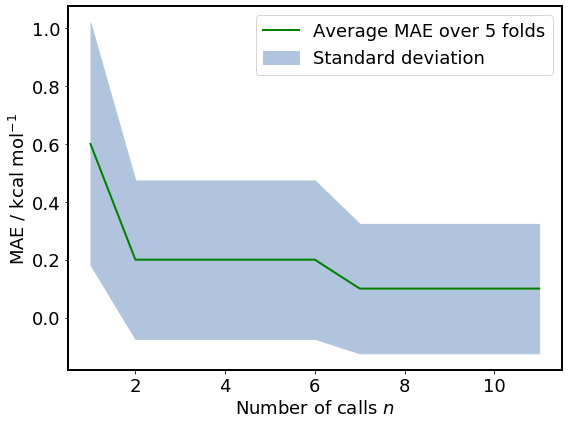

In [11]:
plot = plot_convergence(results, 5, 11)

In [12]:
test_X = test_set.iloc[:,:-1]
test_y = test_set.iloc[:,-1]

In [13]:
def model_predict(model_num, test_entry):
    """Load model from HDF5 and return model prediction on a given test_entry."""

    model = tf.keras.models.load_model('/Users/wilsonwu/OUTBRAIK/outbraik/data/06_models/fold_' + str(model_num) + '_model.h5')

    return model.predict(test_entry)

In [44]:
def test_model(test_set, n_splits):
    n_splits = 5
    test_X = test_set.iloc[:,:-1]
    test_y = test_set.iloc[:,-1]
    predict_per_fold = [model_predict(fold_num, test_X.to_numpy()) for fold_num in range(1, n_splits + 1)]
    predict_y = np.average(predict_per_fold, axis=0)
    
    predict_y = [x[0] for x in predict_y]
    results_dict = {'true': test_y, 'predicted': predict_y}
    df = pd.DataFrame.from_dict(results_dict, orient='columns')
    df.to_csv('/Users/wilsonwu/OUTBRAIK/outbraik/data/08_reporting/predictions.csv')
    
    return df

In [45]:
test_model(test_set, 5)

,true,predicted
Disease,,
2019 Measles Tonga,1.0,0.6
2000 Measles in Ireland,0.0,0.4
2002 SARS China,1.0,0.6


In [30]:
n_splits = 5
predict_per_fold = [model_predict(fold_num, test_X.to_numpy()) for fold_num in range(1, n_splits + 1)]

In [15]:
predict_y = np.average(predict_per_fold, axis=0)
print(predict_y)
print(test_y.values)

[[0.8]
 [0.6]
 [0.8]]
[1. 0. 1.]
